**LLM Zero-shot Reranker Baseline on AmazonBooks**

This script runs a prompted LLM zero-shot reranker for the AmazonBooks dataset using Mistral-7B-Instruct-v0.3-bnb-4bit.
What it does:

*   Loads precomputed splits and 50-item candidate pools from the files in ../dataset/.
*   Loads book metadata (title + summary) amazonbooks_metadata_merged_per_iid_clean.csv.
*   Builds recent reading histories (3–5 items) from train_indexed.parquet.
*   Uses a chat-style prompt to ask the LLM to rank the 50 candidate books.
*   Post-processes the output into a full ranking.
*   Evaluates HR@k and NDCG@k (k = 1, 5, 10, 20) on VAL and TEST.
















In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

print("Loading splits and candidate pools...\n")

# TRAIN: interactions used to build histories
# Columns: [userId, itemId, ts, uid, iid]
train_idx = pd.read_parquet("train_indexed.parquet")

# VAL / TEST targets (indexed)
val_idx  = pd.read_parquet("val_targets_indexed.parquet")
test_idx = pd.read_parquet("test_targets_indexed.parquet")

# Candidate pools: one row per uid, 'candidates' = list of iids
cand_val  = pd.read_parquet("val.parquet")
cand_test = pd.read_parquet("test.parquet")

print("Example candidate lengths (VAL, first 5 rows):",
      [len(c) for c in cand_val["candidates"].head(5)],
      "\n")

n_users_train_raw = train_idx["uid"].nunique()
n_users_val_raw   = val_idx["uid"].nunique()
n_users_test_raw  = test_idx["uid"].nunique()

print("Raw users in TRAIN:", n_users_train_raw)
print("Raw users in VAL targets:", n_users_val_raw)
print("Raw users in TEST targets:", n_users_test_raw)
print()

# Coverage: ensure each user's target iid is in their candidate pool
def mark_coverage(cands_df, targets_df, tgt_col_name: str):
    """
    Merge candidate pools with targets and mark which users have their
    true target item inside the candidate pool.

    cands_df:   DataFrame with columns [uid, candidates]
    targets_df: DataFrame with at least [uid, iid] where iid is the target item
    tgt_col_name: name to give the target iid column in the merged result
    """
    df = cands_df.merge(
        targets_df[["uid", "iid"]].rename(columns={"iid": tgt_col_name}),
        on="uid",
        how="inner",
    )

    # Ensure candidates is always a list
    df["candidates"] = df["candidates"].apply(
        lambda x: list(x) if isinstance(x, (list, tuple, np.ndarray, pd.Series)) else []
    )

    # Clean up target column: fill missing with -1 and cast to int
    df[tgt_col_name] = df[tgt_col_name].fillna(-1).astype(int)

    # Check if target is in candidate pool
    df["target_in_pool"] = [
        int(t) in set(c) for t, c in zip(df[tgt_col_name], df["candidates"])
    ]

    return df

val_cov  = mark_coverage(cand_val,  val_idx,  "target")
test_cov = mark_coverage(cand_test, test_idx, "target")

# Keep only users where the target is in the candidate pool
covered_val  = val_cov[val_cov["target_in_pool"]].copy()
covered_test = test_cov[test_cov["target_in_pool"]].copy()

# Eval-ready
val_eval  = covered_val[["uid", "candidates", "target"]].reset_index(drop=True)
test_eval = covered_test[["uid", "candidates", "target"]].reset_index(drop=True)

print(f"Users with target in pool: VAL={len(val_eval)}  TEST={len(test_eval)}")
print("Eval users in VAL (with target in pool):", val_eval["uid"].nunique())
print("Eval users in TEST (with target in pool):", test_eval["uid"].nunique())
print("\nVAL eval sample:")
print(val_eval.head())

#sanity check
# 1. Candidate pool size distribution
val_cand_lengths = val_eval["candidates"].apply(len)
test_cand_lengths = test_eval["candidates"].apply(len)

print("\nVAL candidate size stats:")
print(val_cand_lengths.describe())
print("\nTEST candidate size stats:")
print(test_cand_lengths.describe())

# 2. Check that every target is actually in its candidate list
val_target_not_in_cands = (~val_eval.apply(lambda row: row["target"] in row["candidates"], axis=1)).mean()
test_target_not_in_cands = (~test_eval.apply(lambda row: row["target"] in row["candidates"], axis=1)).mean()

print(f"\nVAL: fraction where target NOT in candidates (should be 0): {val_target_not_in_cands:.4f}")
print(f"TEST: fraction where target NOT in candidates (should be 0): {test_target_not_in_cands:.4f}")


Loading splits and candidate pools...

Example candidate lengths (VAL, first 5 rows): [52, 52, 52, 52, 52] 

Raw users in TRAIN: 14064
Raw users in VAL targets: 100
Raw users in TEST targets: 100

Users with target in pool: VAL=100  TEST=100
Eval users in VAL (with target in pool): 100
Eval users in TEST (with target in pool): 100

VAL eval sample:
   uid                                         candidates  target
0    0  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...   12521
1    1  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...    8721
2    2  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...    7313
3    3  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...   16287
4    4  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...    5244

VAL candidate size stats:
count    100.00
mean      51.99
std        0.10
min       51.00
25%       52.00
50%       52.00
75%       52.00
max       52.00
Name: candidates, dtype: float64

TEST candidate size stats:
count    100.00
mean      51.99
std  

In [ ]:
# 1. Load metadata
books_meta = pd.read_csv("amazonbooks_metadata_merged_per_iid_clean.csv")

print("Metadata columns before:", books_meta.columns.tolist())
print("Number of rows:", len(books_meta))

# Ensure required columns exist
if "description" not in books_meta.columns:
    books_meta["description"] = ""
    print("Added 'description' column (blank for now).")

# Clean types
books_meta["title"]       = books_meta["title"].fillna("").astype(str)
books_meta["description"] = books_meta["description"].fillna("").astype(str)

#ensuring iid is int
books_meta["iid"] = books_meta["iid"].astype(int)

print("Metadata columns after:", books_meta.columns.tolist())
print(books_meta.head())

# Build iid_to_meta dictionary
iid_to_meta = {}

for _, row in books_meta.iterrows():
    iid   = int(row["iid"])
    title = row["title"].strip()
    desc  = row["description"].strip()

    # Take only the first sentence and cap the length
    first_sentence = desc.split(".")[0].strip()
    short_desc = first_sentence[:160]

    iid_to_meta[iid] = {
        "title": title,
        "short_desc": short_desc,
    }

print("iid_to_meta loaded with", len(iid_to_meta), "items.")

#check metadata coverage over candidates
def metadata_coverage(eval_df, iid_to_meta, n_users=50):
    subset = eval_df.head(n_users)
    total = 0
    with_meta = 0
    for _, row in subset.iterrows():
        for iid in row["candidates"]:
            total += 1
            if int(iid) in iid_to_meta:
                with_meta += 1
    return with_meta / total if total > 0 else 0.0

val_meta_cov = metadata_coverage(val_eval, iid_to_meta, n_users=100)
test_meta_cov = metadata_coverage(test_eval, iid_to_meta, n_users=100)

print(f"\nMetadata coverage on VAL candidates (first 100 users): {val_meta_cov:.3f}")
print(f"Metadata coverage on TEST candidates (first 100 users): {test_meta_cov:.3f}")

Metadata columns before: ['itemId', 'iid', 'title', 'description']
Number of rows: 18783
Metadata columns after: ['itemId', 'iid', 'title', 'description']
       itemId  iid                                              title  \
0  0001047655    0                              The Prodigal Daughter   
1  0001047736    1                                Summer of the Danes   
2  0001047876    2                             Life of Samuel Johnson   
3  0001048228    3                                    Pale Battalions   
4  0001049143    4  The Poems & Songs of Robert Burns (HarperColli...   

                                         description  
0  I read Kane & Abel and think it was perhaps th...  
1  It is not the summer of his discontent, washed...  
2  I liked this but prefer the unabridged edition...  
3  It is difficult to be so subtle and so dazzlin...  
4  Many years ago, a friend with grandparents fro...  
iid_to_meta loaded with 18783 items.

Metadata coverage on VAL candidates (f

In [ ]:
def build_history_iids(train_df, eval_uids, max_history_items=5):
    """
    For each uid in eval_uids, take their last `max_history_items` iids
    from the training interactions and return them as a list.
    """
    subset = train_df[train_df["uid"].isin(eval_uids)].copy()
    subset = subset.sort_values(["uid", "ts"])

    history_df = (
        subset
        .groupby("uid")["iid"]
        .apply(lambda x: list(x.tail(max_history_items)))
        .reset_index(name="history_iids")
    )

    return history_df

# ---- VAL histories ----
val_uids = covered_val["uid"].unique()
val_history_iids = build_history_iids(train_idx, val_uids, max_history_items=5)

print("VAL history_iids sample:")
print(val_history_iids.head())
print("Number of VAL users with history:", len(val_history_iids))

# ---- TEST histories ----
test_uids = covered_test["uid"].unique()
test_history_iids = build_history_iids(train_idx, test_uids, max_history_items=5)

print("TEST history_iids sample:")
print(test_history_iids.head())
print("Number of TEST users with history:", len(test_history_iids))

val_hist_lengths = val_history_iids["history_iids"].apply(len)
test_hist_lengths = test_history_iids["history_iids"].apply(len)

print("\nVAL history length stats:")
print(val_hist_lengths.describe())

print("\nTEST history length stats:")
print(test_hist_lengths.describe())

VAL history_iids sample:
   uid                    history_iids
0    0        [1043, 1044, 6435, 9755]
1    1  [1340, 1717, 1886, 4071, 7521]
2    2         [755, 2831, 3938, 4538]
3    3            [3970, 14090, 14149]
4    4         [628, 2122, 5055, 5057]
Number of VAL users with history: 100
TEST history_iids sample:
   uid                    history_iids
0    0        [1043, 1044, 6435, 9755]
1    1  [1340, 1717, 1886, 4071, 7521]
2    2         [755, 2831, 3938, 4538]
3    3            [3970, 14090, 14149]
4    4         [628, 2122, 5055, 5057]
Number of TEST users with history: 100

VAL history length stats:
count    100.000000
mean       4.090000
std        0.911154
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: history_iids, dtype: float64

TEST history length stats:
count    100.000000
mean       4.090000
std        0.911154
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.0

In [ ]:
def map_iids_to_text(iid_list, iid_to_meta, include_ids=False):
    """
    Map a list of iids to human-readable strings with clear separation
    between title and summary.

    """
    mapped = []

    for iid in iid_list:
        meta = iid_to_meta.get(int(iid))
        if meta is None:
            continue

        title = meta.get("title", "").strip()
        short = meta.get("short_desc", "").strip()

        parts = []
        if title:
            parts.append(f"Title: {title}")
        if short:
            parts.append(f"Summary: {short}")

        if not parts:
            continue

        text = " | ".join(parts)

        if include_ids:
            text = f"ID={int(iid)} | {text}"

        mapped.append(text)

    return mapped

# VAL user histories mapped to readable text
val_history_iids["history_text_list"] = val_history_iids["history_iids"].apply(
    lambda ids: map_iids_to_text(ids, iid_to_meta)
)

print("Sample VAL history_text_list:")
print(val_history_iids.head())

# TEST user histories mapped to readable text
test_history_iids["history_text_list"] = test_history_iids["history_iids"].apply(
    lambda ids: map_iids_to_text(ids, iid_to_meta)
)

print("Sample TEST history_text_list:")
print(test_history_iids.head())


Sample VAL history_text_list:
   uid                    history_iids  \
0    0        [1043, 1044, 6435, 9755]   
1    1  [1340, 1717, 1886, 4071, 7521]   
2    2         [755, 2831, 3938, 4538]   
3    3            [3970, 14090, 14149]   
4    4         [628, 2122, 5055, 5057]   

                                   history_text_list  
0  [Title: 20,000 Leagues Under the Sea (Progress...  
1  [Title: The Awakening: Complete, Authoritative...  
2  [Title: The Importance of Being Earnest (Pengu...  
3  [Title: Holy Bible: New International Version ...  
4  [Title: If This Is a Man and The Truce (Pengui...  
Sample TEST history_text_list:
   uid                    history_iids  \
0    0        [1043, 1044, 6435, 9755]   
1    1  [1340, 1717, 1886, 4071, 7521]   
2    2         [755, 2831, 3938, 4538]   
3    3            [3970, 14090, 14149]   
4    4         [628, 2122, 5055, 5057]   

                                   history_text_list  
0  [Title: 20,000 Leagues Under the Sea (Progres

In [ ]:
def build_history_text(history_text_list):
    """
    Turn a list of book strings into a numbered history block.

    """
    if not history_text_list:
        return (
            "I have not read many books yet. "
            "Please recommend from the candidate books below."
        )

    lines = ["I have recently read the following books:"]
    for idx, book_str in enumerate(history_text_list, start=1):
        lines.append(f"{idx}. {book_str}")

    return "\n".join(lines)

# VAL history_text
val_history_iids["history_text"] = val_history_iids["history_text_list"].apply(
    build_history_text
)
print("Sample VAL history_text:")
print(val_history_iids[["uid", "history_text"]].head(3))

# TEST history_text
test_history_iids["history_text"] = test_history_iids["history_text_list"].apply(
    build_history_text
)
print("Sample TEST history_text:")
print(test_history_iids[["uid", "history_text"]].head(3))


Sample VAL history_text:
   uid                                       history_text
0    0  I have recently read the following books:\n1. ...
1    1  I have recently read the following books:\n1. ...
2    2  I have recently read the following books:\n1. ...
Sample TEST history_text:
   uid                                       history_text
0    0  I have recently read the following books:\n1. ...
1    1  I have recently read the following books:\n1. ...
2    2  I have recently read the following books:\n1. ...


In [ ]:
# Map candidate pools (VAL/TEST) to candidate_books
cand_val["candidate_books"] = cand_val["candidates"].apply(
    lambda ids: map_iids_to_text(ids, iid_to_meta, include_ids=True)
)

cand_test["candidate_books"] = cand_test["candidates"].apply(
    lambda ids: map_iids_to_text(ids, iid_to_meta, include_ids=True)
)

print("Sample mapped VAL candidates:")
print(cand_val.head())

print("Sample mapped TEST candidates:")
print(cand_test.head())


Sample mapped VAL candidates:
   uid                                         candidates  \
0    0  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...   
1    1  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...   
2    2  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...   
3    3  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...   
4    4  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...   

                                     candidate_books  
0  [ID=7315 | Title: Harper Lee's To Kill a Mocki...  
1  [ID=7315 | Title: Harper Lee's To Kill a Mocki...  
2  [ID=7315 | Title: Harper Lee's To Kill a Mocki...  
3  [ID=7315 | Title: Harper Lee's To Kill a Mocki...  
4  [ID=7315 | Title: Harper Lee's To Kill a Mocki...  
Sample mapped TEST candidates:
   uid                                         candidates  \
0    0  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...   
1    1  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...   
2    2  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...  

In [ ]:
# Merge candidate pools with user histories
# VAL
val_merged = covered_val.merge(
    val_history_iids[["uid", "history_text"]],
    on="uid",
    how="left"
)

print("VAL merged sample:")
print(val_merged.head())
print("VAL merged columns:", val_merged.columns.tolist())

# TEST
test_merged = covered_test.merge(
    test_history_iids[["uid", "history_text"]],
    on="uid",
    how="left"
)

print("TEST merged sample:")
print(test_merged.head())
print("TEST merged columns:", test_merged.columns.tolist())

print("\nVAL: fraction of rows with missing history_text:",
      val_merged["history_text"].isna().mean())
print("TEST: fraction of rows with missing history_text:",
      test_merged["history_text"].isna().mean())


VAL merged sample:
   uid                                         candidates  target  \
0    0  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...   12521   
1    1  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...    8721   
2    2  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...    7313   
3    3  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...   16287   
4    4  [7315, 7908, 13042, 11033, 4582, 14470, 14754,...    5244   

   target_in_pool                                       history_text  
0            True  I have recently read the following books:\n1. ...  
1            True  I have recently read the following books:\n1. ...  
2            True  I have recently read the following books:\n1. ...  
3            True  I have recently read the following books:\n1. ...  
4            True  I have recently read the following books:\n1. ...  
VAL merged columns: ['uid', 'candidates', 'target', 'target_in_pool', 'history_text']
TEST merged sample:
   uid                            

In [ ]:
# Ensure target is int
val_merged["target"]  = val_merged["target"].astype(int)
test_merged["target"] = test_merged["target"].astype(int)

#main DataFrames
val_prompts_base  = val_merged.copy()
test_prompts_base = test_merged.copy()

#Adding title and summary to candidate books (WITH IDs)
val_prompts_base["candidate_books"] = val_prompts_base["candidates"].apply(
    lambda ids: map_iids_to_text(ids, iid_to_meta, include_ids=True)
)

test_prompts_base["candidate_books"] = test_prompts_base["candidates"].apply(
    lambda ids: map_iids_to_text(ids, iid_to_meta, include_ids=True)
)

print("VAL sample candidate_books:")
print(val_prompts_base[["uid", "candidate_books"]].head())

print("\nTEST sample candidate_books:")
print(test_prompts_base[["uid", "candidate_books"]].head())

print("VAL final base columns:", val_prompts_base.columns.tolist())
print("TEST final base columns:", test_prompts_base.columns.tolist())

VAL sample candidate_books:
   uid                                    candidate_books
0    0  [ID=7315 | Title: Harper Lee's To Kill a Mocki...
1    1  [ID=7315 | Title: Harper Lee's To Kill a Mocki...
2    2  [ID=7315 | Title: Harper Lee's To Kill a Mocki...
3    3  [ID=7315 | Title: Harper Lee's To Kill a Mocki...
4    4  [ID=7315 | Title: Harper Lee's To Kill a Mocki...

TEST sample candidate_books:
   uid                                    candidate_books
0    0  [ID=7315 | Title: Harper Lee's To Kill a Mocki...
1    1  [ID=7315 | Title: Harper Lee's To Kill a Mocki...
2    2  [ID=7315 | Title: Harper Lee's To Kill a Mocki...
3    3  [ID=7315 | Title: Harper Lee's To Kill a Mocki...
4    4  [ID=7315 | Title: Harper Lee's To Kill a Mocki...
VAL final base columns: ['uid', 'candidates', 'target', 'target_in_pool', 'history_text', 'candidate_books']
TEST final base columns: ['uid', 'candidates', 'target', 'target_in_pool', 'history_text', 'candidate_books']


In [ ]:
# Inspect a single VAL user row in detail
i = 5  #to choose user

row = val_prompts_base.iloc[i]

uid    = int(row["uid"])
target = int(row["target"])
cands  = list(row["candidates"])

print(f"VAL ROW DEBUG: index={i}, uid={uid}\n")

#Target info
print(f"Target iid: {target}")
target_meta  = iid_to_meta.get(target, {})
t_title      = target_meta.get("title", "[NO TITLE]").strip()
t_short_desc = target_meta.get("short_desc", "").strip()

if t_short_desc:
    target_text = f"Title: {t_title} | Summary: {t_short_desc}"
else:
    target_text = f"Title: {t_title}"

print("Target text:", target_text)
print("\n")

#History block shown to LLM
print("HISTORY TEXT (history_text)")
print(row["history_text"])
print("\n")

#Candidate pool: iids + title/summary
print("CANDIDATE POOL (iid + text)\n")
for pos, iid in enumerate(cands, start=1):
    iid_int = int(iid)
    meta  = iid_to_meta.get(iid_int, {})
    title = meta.get("title", "[NO TITLE]").strip()
    short = meta.get("short_desc", "").strip()

    if short:
        item_text = f"Title: {title} | Summary: {short}"
    else:
        item_text = f"Title: {title}"

    print(f"{pos:2d}. IID={iid_int}")
    print(f"    Text: {item_text}\n")

#If candidate_books column exists, show it too
if "candidate_books" in val_prompts_base.columns:
    print("candidate_books (if present)")
    print(row["candidate_books"])


===== VAL ROW DEBUG: index=5, uid=5 =====

Target iid: 10643
Target text: Title: Air Disaster (Vol. 1) | Summary: I've read all three Air Disaster books, and in my opinion, this is the best one


----- HISTORY TEXT (history_text) -----
I have recently read the following books:
1. Title: Choice, The | Summary: It goes without saying that any book by Trask or Goodall is worth it's weight in gold
2. Title: Unstoppable: 45 Powerful Stories of Perseverance and Triumph from People Just Like You | Summary: I enjoyed this book
3. Title: The Five Love Languages: The Secret to Love that Lasts | Summary: I love this book, I actually already had this book in paperback, but I simply had to have it electronically so that I could have it with me at all time


----- CANDIDATE POOL (iid + text) -----

 1. IID=7315
    Text: Title: Harper Lee's To Kill a Mockingbird (Barron's Book Notes) | Summary: At the beginning of the book, I didn't think it was very good and it was kind of boring

 2. IID=7908
    

In [ ]:
!pip install -q transformers accelerate bitsandbytes tqdm

import torch
import json
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "unsloth/Mistral-7B-Instruct-v0.3-bnb-4bit"

print("Loading model:", model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

model.eval()
print("Model loaded on:", model.device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 47.3 MB/s eta 0:00:00
Loading model: unsloth/Mistral-7B-Instruct-v0.3-bnb-4bit


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/4.14G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/157 [00:00<?, ?B/s]

Model loaded on: cuda:0


In [ ]:
SYSTEM_PROMPT = (
    "You are a book recommendation assistant working on a research dataset. "
    "You are given a user's recent reading history and a list of candidate books. "
    "Each candidate has an internal numeric ID. "
    "Your job is to decide which candidate books this specific user is most "
    "likely to read next, based ONLY on the information provided. "
    "Assume all candidate books are equally popular and equally well-reviewed. "
    "Do NOT favor famous 'classics' just because they are famous. "
    "You must follow the requested output format exactly."
)

def build_messages_for_row(row, top_k=10):
    """
    Build chat messages for a single row from val_prompts_base / test_prompts_base.

    Expects columns:
      - uid
      - history_text         (string)
      - candidate_books      (list of 'ID=<iid>: <text>' strings)
    """
    uid = int(row["uid"])

    # History
    history_text = row.get("history_text", "")
    if not isinstance(history_text, str) or not history_text.strip():
        history_block = (
            "The user does not have much reading history.\n"
            "Please rely on the candidate book descriptions only."
        )
    else:
        history_block = history_text

    # Candidates from the precomputed column
    candidate_books = row.get("candidate_books", [])
    if not isinstance(candidate_books, (list, tuple)) or len(candidate_books) == 0:
        raise ValueError(f"Row uid={uid} has no candidate_books; cannot build prompt.")

    cand_lines = ["Candidates:"]
    for idx, cand_str in enumerate(candidate_books, start=1):
        cand_lines.append(f"{idx}. {cand_str}")
    candidates_block = "\n".join(cand_lines)

    user_content = f"""
Here is a user and their recent reading history:

{history_block}

Here is a list of candidate books. Each line has an internal ID and a short description.

{candidates_block}

Task:
From the candidate list, select the TOP {top_k} books this user is most likely
to read next, ranking them from most likely to least likely.

Important guidelines:
- Assume ALL candidate books are equally popular and equally well-reviewed.
- Do NOT favor well-known or classic books just because they are famous.
- Base your ranking ONLY on:
  * how similar each candidate's topic, genre, style, and tone are to the user's recent reading history; and
  * clear patterns you can infer from the user's past books.
- If a candidate does not fit the user's history at all, rank it lower
  even if it is a classic or famous title.

Rules about IDs and format:
- Only choose IDs from the candidate list (e.g., ID=7315).
- Do NOT invent new IDs or books.
- Do NOT repeat the same ID more than once.
- Aim to return exactly {top_k} DISTINCT IDs if possible.
- If you are unsure about some books, still include them to reach {top_k} unique IDs.

Output format:
Return your answer as a JSON list of IDs only (as integers), in order, with no extra text.
For example: [19089, 20536, 16114, 23872, 24429]

Now return the JSON list of candidate IDs for this user.
""".strip()

    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user",   "content": user_content},
    ]
    return messages

def extract_json_list(text: str):
    first = text.find("[")
    last  = text.rfind("]")
    if first == -1 or last == -1 or last <= first:
        return []
    snippet = text[first:last+1]
    try:
        parsed = json.loads(snippet)
        if isinstance(parsed, list):
            return parsed
    except Exception:
        return []
    return []

def llm_rerank_row(row, top_k=10,
                   max_new_tokens=256, temperature=0.0):
    candidate_iids = list(row["candidates"])
    if not candidate_iids:
        return [], ""

    cand_set = set(int(x) for x in candidate_iids)

    messages = build_messages_for_row(row, top_k=top_k)

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=False,
        )

    gen_tokens = outputs[0, input_ids.shape[-1]:]
    text = tokenizer.decode(gen_tokens, skip_special_tokens=True).strip()

    raw_list = extract_json_list(text)

    ranked_ids = []
    for x in raw_list:
        try:
            iid_int = int(x)
        except Exception:
            continue
        if iid_int in cand_set and iid_int not in ranked_ids:
            ranked_ids.append(iid_int)

    # Pad with remaining candidates (in original order) so eval always has a full ranking
    if len(ranked_ids) < len(candidate_iids):
        remaining = [iid for iid in candidate_iids if iid not in ranked_ids]
        ranked_ids.extend(remaining)

    return ranked_ids, text


In [ ]:
import math
import numpy as np
from tqdm import tqdm

def hit_at_k(ranked_ids, target_id, k=10):
    return 1.0 if target_id in ranked_ids[:k] else 0.0

def ndcg_at_k(ranked_ids, target_id, k=10):
    for rank, iid in enumerate(ranked_ids[:k], start=1):
        if iid == target_id:
            return 1.0 / math.log2(rank + 1)
    return 0.0

def eval_llm_on_split(df, split_name, top_k=10, max_users=None):
    hits = []
    ndcgs = []
    logs = []

    n_total = len(df)
    n_users = n_total if max_users is None else min(n_total, max_users)

    print(f"\nEvaluating LLM on {split_name} for {n_users} users...")

    empty_count = 0
    short_count = 0

    for idx, row in tqdm(df.iloc[:n_users].iterrows(),
                         total=n_users, desc=f"{split_name} users"):
        uid    = int(row["uid"])
        target = int(row["target"])

        ranked_ids, raw_text = llm_rerank_row(
            row,
            top_k=top_k,
            max_new_tokens=256,
            temperature=0.0,
        )

        if not ranked_ids:
            empty_count += 1
            continue

        if len(ranked_ids) < top_k:
            short_count += 1

        h = hit_at_k(ranked_ids, target, k=top_k)
        d = ndcg_at_k(ranked_ids, target, k=top_k)
        hits.append(h)
        ndcgs.append(d)

        logs.append({
            "row_index": int(idx),
            "uid": uid,
            "target": target,
            "candidate_iids": [int(i) for i in row["candidates"]],
            "ranked_ids": [int(i) for i in ranked_ids],
            "raw_output": raw_text,
        })

    hr   = float(np.mean(hits)) if hits else 0.0
    ndcg = float(np.mean(ndcgs)) if ndcgs else 0.0

    print(f"[{split_name}] Zero-shot LLM HR@{top_k} = {hr:.3f}  NDCG@{top_k} = {ndcg:.3f}")
    print(f"Users evaluated: {len(hits)} (out of {n_users})")
    print(f"Fraction rows with empty ranking: {empty_count / n_users:.3f}")
    print(f"Fraction rows with <K ranking:    {short_count / n_users:.3f}")

    return hr, ndcg, logs

K_VALUES = [1, 5, 10, 20]

for k in K_VALUES:
    print(f"\n Evaluating Zero-Shot LLM at k = {k}")
    val_hr, val_ndcg, _ = eval_llm_on_split(
        val_prompts_base,
        split_name="VAL",
        top_k=k,
        max_users=None,
    )
    print(f"VAL HR@{k}   = {val_hr:.3f}")
    print(f"VAL NDCG@{k} = {val_ndcg:.3f}")

for k in K_VALUES:
    print(f"\n Evaluating Zero-Shot LLM on TEST at k = {k} ")
    test_hr, test_ndcg, _ = eval_llm_on_split(
        test_prompts_base,
        split_name="TEST",
        top_k=k,
        max_users=None,
    )
    print(f"TEST HR@{k}   = {test_hr:.3f}")
    print(f"TEST NDCG@{k} = {test_ndcg:.3f}")


 Evaluating Zero-Shot LLM at k = 1

Evaluating LLM on VAL for 100 users...


VAL users: 100%|██████████| 100/100 [11:39<00:00,  6.99s/it]


[VAL] Zero-shot LLM HR@1 = 0.030  NDCG@1 = 0.030
Users evaluated: 100 (out of 100)
Fraction rows with empty ranking: 0.000
Fraction rows with <K ranking:    0.000
VAL HR@1   = 0.030
VAL NDCG@1 = 0.030

 Evaluating Zero-Shot LLM at k = 5

Evaluating LLM on VAL for 100 users...


VAL users: 100%|██████████| 100/100 [07:59<00:00,  4.79s/it]


[VAL] Zero-shot LLM HR@5 = 0.100  NDCG@5 = 0.064
Users evaluated: 100 (out of 100)
Fraction rows with empty ranking: 0.000
Fraction rows with <K ranking:    0.000
VAL HR@5   = 0.100
VAL NDCG@5 = 0.064

 Evaluating Zero-Shot LLM at k = 10

Evaluating LLM on VAL for 100 users...


VAL users: 100%|██████████| 100/100 [11:32<00:00,  6.92s/it]


[VAL] Zero-shot LLM HR@10 = 0.210  NDCG@10 = 0.094
Users evaluated: 100 (out of 100)
Fraction rows with empty ranking: 0.000
Fraction rows with <K ranking:    0.000
VAL HR@10   = 0.210
VAL NDCG@10 = 0.094

 Evaluating Zero-Shot LLM at k = 20

Evaluating LLM on VAL for 100 users...


VAL users: 100%|██████████| 100/100 [19:05<00:00, 11.46s/it]


[VAL] Zero-shot LLM HR@20 = 0.190  NDCG@20 = 0.083
Users evaluated: 100 (out of 100)
Fraction rows with empty ranking: 0.000
Fraction rows with <K ranking:    0.000
VAL HR@20   = 0.190
VAL NDCG@20 = 0.083

 Evaluating Zero-Shot LLM on TEST at k = 1 

Evaluating LLM on TEST for 100 users...


TEST users: 100%|██████████| 100/100 [11:37<00:00,  6.97s/it]


[TEST] Zero-shot LLM HR@1 = 0.020  NDCG@1 = 0.020
Users evaluated: 100 (out of 100)
Fraction rows with empty ranking: 0.000
Fraction rows with <K ranking:    0.000
TEST HR@1   = 0.020
TEST NDCG@1 = 0.020

 Evaluating Zero-Shot LLM on TEST at k = 5 

Evaluating LLM on TEST for 100 users...


TEST users: 100%|██████████| 100/100 [08:00<00:00,  4.81s/it]


[TEST] Zero-shot LLM HR@5 = 0.070  NDCG@5 = 0.040
Users evaluated: 100 (out of 100)
Fraction rows with empty ranking: 0.000
Fraction rows with <K ranking:    0.000
TEST HR@5   = 0.070
TEST NDCG@5 = 0.040

 Evaluating Zero-Shot LLM on TEST at k = 10 

Evaluating LLM on TEST for 100 users...


TEST users: 100%|██████████| 100/100 [11:34<00:00,  6.95s/it]


[TEST] Zero-shot LLM HR@10 = 0.100  NDCG@10 = 0.053
Users evaluated: 100 (out of 100)
Fraction rows with empty ranking: 0.000
Fraction rows with <K ranking:    0.000
TEST HR@10   = 0.100
TEST NDCG@10 = 0.053

 Evaluating Zero-Shot LLM on TEST at k = 20 

Evaluating LLM on TEST for 100 users...


TEST users: 100%|██████████| 100/100 [19:07<00:00, 11.48s/it]

[TEST] Zero-shot LLM HR@20 = 0.160  NDCG@20 = 0.067
Users evaluated: 100 (out of 100)
Fraction rows with empty ranking: 0.000
Fraction rows with <K ranking:    0.000
TEST HR@20   = 0.160
TEST NDCG@20 = 0.067


**Fine-tuning Mistral-7B-Instruct on AmazonBooks (CTR-style)**

This section extends the zero-shot reranker into a fine-tuned model that learns a binary “YES / NO” preference classifier (CTR-style). The fine-tuned model is then used to score and rank the same 50-item candidate pools used in the zero-shot evaluation.

*   Build a CTR-style dataset from the AmazonBooks training interactions:
each training example consists of (user history, candidate item, label ∈ {YES, NO}), with negatives sampled from items the user has not seen.
*   Convert each example into an instruction-style prompt that shows the user’s reading history, one candidate book (title + summary), and the expected answer (“YES” or “NO”).
*   Fine-tune the Mistral-7B-Instruct-4bit model with LoRA using Unsloth, training on the generated prompts for several hundred steps.
*   At inference time, score each candidate in the pool with p(YES | history, candidate) and rank items by this probability.
*   Evaluate ranking quality using HR@k and NDCG@k on the same VAL and TEST users used in the zero-shot reranker.








In [ ]:
import numpy as np
import pandas as pd

# CTR dataset hyperparameters
MAX_HISTORY_LEN_CTR   = 10       # how many past items to keep per example
NUM_NEGATIVES_PER_POS = 1        # negatives per positive
MAX_TRAIN_EXAMPLES    = 15_000   # cap for training examples
VAL_FRACTION          = 0.1      # later used for train/val split
RANDOM_SEED_CTR       = 42

rng = np.random.default_rng(RANDOM_SEED_CTR)

#Build user-full interaction sequence (by iid)
print("Building user sequences from train_idx for CTR...")

#Ensure correct sorting by time
train_sorted_ctr = train_idx.sort_values(["uid", "ts"])

#user_seqs: uid - [iid1, iid2, ..., iidT] in chronological order
user_seqs = train_sorted_ctr.groupby("uid")["iid"].apply(list).to_dict()

print(f"Number of users in train_idx: {len(user_seqs)}")

#Define item universe for negative sampling
all_items = np.array(sorted(iid_to_meta.keys()), dtype=np.int32)
n_items   = len(all_items)
print(f"Item universe size (from iid_to_meta): {n_items}")

#Generate CTR examples: (uid, history, item, label)
ctr_examples = []

for uid, seq in user_seqs.items():
    # Need at least 2 interactions to form history + next-item pair
    if len(seq) < 2:
        continue

    user_pos_set = set(int(i) for i in seq)  # items this user has interacted with

    #For each position t, seq[:t] is history and seq[t] is the positive target
    for t in range(1, len(seq)):
        history = [int(i) for i in seq[:t]]
        target  = int(seq[t])

        # Truncate history to last MAX_HISTORY_LEN_CTR items
        hist_trunc = history[-MAX_HISTORY_LEN_CTR:]

        #Positive example
        ctr_examples.append(
            {
                "uid": int(uid),
                "history": hist_trunc,
                "item": target,
                "label": 1,
            }
        )

        #Negative examples
        for _ in range(NUM_NEGATIVES_PER_POS):
            neg_item = None

            # Simple rejection sampling: sample until we hit an item
            # the user has never interacted with.
            while True:
                candidate_neg = int(rng.choice(all_items))
                if candidate_neg not in user_pos_set:
                    neg_item = candidate_neg
                    break

            ctr_examples.append(
                {
                    "uid": int(uid),
                    "history": hist_trunc,
                    "item": neg_item,
                    "label": 0,
                }
            )

print(f"\nBuilt {len(ctr_examples)} raw CTR examples before capping.")

#Shuffle and cap to MAX_TRAIN_EXAMPLES
rng.shuffle(ctr_examples)

if len(ctr_examples) > MAX_TRAIN_EXAMPLES:
    ctr_examples = ctr_examples[:MAX_TRAIN_EXAMPLES]

print(f"After capping: {len(ctr_examples)} CTR examples.")

#Convert to DataFrame
ctr_df = pd.DataFrame(ctr_examples)

print("\nCTR DataFrame head:")
print(ctr_df.head())

print("\nLabel distribution (0=NO, 1=YES):")
print(ctr_df["label"].value_counts(normalize=True))

#Train/val split (on rows)
val_size = int(len(ctr_df) * VAL_FRACTION)
train_df_ctr = ctr_df.iloc[:-val_size].reset_index(drop=True)
val_df_ctr   = ctr_df.iloc[-val_size:].reset_index(drop=True)

print(f"\nFinal CTR df sizes → total: {len(ctr_df)}, "
      f"train: {len(train_df_ctr)}, val: {len(val_df_ctr)}")


Building user sequences from train_idx for CTR...
Number of users in train_idx: 14064
Item universe size (from iid_to_meta): 18783

Built 92944 raw CTR examples before capping.
After capping: 15000 CTR examples.

CTR DataFrame head:
    uid                       history   item  label
0  3048          [7521, 11188, 11471]  12280      0
1  5409                         [980]   4487      0
2  3728                         [756]   2989      1
3  2856                  [2715, 3261]   8073      0
4  6200  [13990, 14331, 14659, 15332]  13862      0

Label distribution (0=NO, 1=YES):
label
1    0.504067
0    0.495933
Name: proportion, dtype: float64

Final CTR df sizes → total: 15000, train: 13500, val: 1500


In [ ]:
from tqdm import tqdm

# Helper: Convert a list of iids into USER HISTORY lines
def build_history_block(history_iids, iid_to_meta):
    """
    Convert history iids into lines like:
    - Title: X | Summary: Y
    """
    lines = []
    for iid in history_iids:
        meta = iid_to_meta.get(int(iid), None)
        if meta is None:
            continue

        title = meta.get("title", "").strip()
        summ  = meta.get("short_desc", "").strip()

        if title == "" and summ == "":
            continue

        if summ:
            line = f"- Title: {title} | Summary: {summ}"
        else:
            line = f"- Title: {title}"
        lines.append(line)

    if len(lines) == 0:
        lines.append("- No meaningful history available.")
    return "\n".join(lines)

# Helper: Convert one (history, item, label) into full text
def build_ctr_prompt(history_iids, candidate_iid, label, iid_to_meta, eos_token="</s>"):
    meta = iid_to_meta.get(int(candidate_iid), {})

    cand_title = meta.get("title", "").strip() or "Unknown Title"
    cand_summ  = meta.get("short_desc", "").strip()

    history_block = build_history_block(history_iids, iid_to_meta)

    if cand_summ:
        cand_block = f"Title: {cand_title}\nSummary: {cand_summ}"
    else:
        cand_block = f"Title: {cand_title}"

    # Convert label 1 → YES, 0 → NO
    final_label = "YES" if label == 1 else "NO"

    text = f"""You are a book recommendation assistant.
Given a user's reading history and ONE candidate book, decide if the user is likely to enjoy the candidate.
Answer with exactly one word: YES or NO.

[USER HISTORY]
{history_block}

[CANDIDATE]
{cand_block}

[QUESTION]
Will the user like this book?

[ANSWER]
{final_label}
{eos_token}
"""
    return text

# Build the "text" column for ctr_df
print("Building text prompts for CTR fine-tuning...")

ctr_texts = []
for idx, row in tqdm(ctr_df.iterrows(), total=len(ctr_df)):
    hist_iids = row["history"]
    item_iid  = row["item"]
    label     = row["label"]

    text = build_ctr_prompt(
        history_iids = hist_iids,
        candidate_iid = item_iid,
        label = label,
        iid_to_meta = iid_to_meta,
        eos_token = "</s>"
    )
    ctr_texts.append(text)

ctr_df["text"] = ctr_texts

print("Example CTR prompt:\n")
print(ctr_df["text"].iloc[3])


Building text prompts for CTR fine-tuning...


100%|██████████| 15000/15000 [00:00<00:00, 20620.27it/s]

Example CTR prompt:

You are a book recommendation assistant.
Given a user's reading history and ONE candidate book, decide if the user is likely to enjoy the candidate.
Answer with exactly one word: YES or NO.

[USER HISTORY]
- Title: The Stranger | Summary: Chris VanAllsburg has created another literary masterpiece
- Title: Exporting America: Why Corporate Greed Is Shipping American Jobs Overseas | Summary: I think he needs to get a lesson in basic economics

[CANDIDATE]
Title: Thendara House (Darkover)
Summary: "Thendara House" is a sequel, of sorts, to the previous Darkover novel "The Shattered Chain

[QUESTION]
Will the user like this book?

[ANSWER]
NO
</s>



In [ ]:
from datasets import Dataset, DatasetDict

# Use same hyperparams as before
VAL_FRACTION = 0.1

#Recompute split so train/val have the text column too
val_size = int(len(ctr_df) * VAL_FRACTION)

train_df_ctr = ctr_df.iloc[:-val_size].reset_index(drop=True)
val_df_ctr   = ctr_df.iloc[-val_size:].reset_index(drop=True)

print(f"CTR df sizes → total: {len(ctr_df)}, train: {len(train_df_ctr)}, val: {len(val_df_ctr)}")

#Sanity check
print("\nTrain CTR sample row:")
print(train_df_ctr.head(1)[["uid", "history", "item", "label", "text"]])

print("\nVal CTR sample row:")
print(val_df_ctr.head(1)[["uid", "history", "item", "label", "text"]])

#Build HF datasets with only the 'text' field (for SFTTrainer)
train_dataset_ctr = Dataset.from_pandas(train_df_ctr[["text"]])
val_dataset_ctr   = Dataset.from_pandas(val_df_ctr[["text"]])

print("\nHF train_dataset_ctr:", train_dataset_ctr)
print("HF val_dataset_ctr:", val_dataset_ctr)

ctr_ds = DatasetDict({
    "train": train_dataset_ctr,
    "val":   val_dataset_ctr,
})

print("Train dataset size:", len(ctr_ds["train"]))
print("Val dataset size:", len(ctr_ds["val"]))


CTR df sizes → total: 15000, train: 13500, val: 1500

Train CTR sample row:
    uid               history   item  label  \
0  3048  [7521, 11188, 11471]  12280      0   

                                                text  
0  You are a book recommendation assistant.\nGive...  

Val CTR sample row:
   uid history   item  label  \
0  632  [9706]  14019      0   

                                                text  
0  You are a book recommendation assistant.\nGive...  

HF train_dataset_ctr: Dataset({
    features: ['text'],
    num_rows: 13500
})
HF val_dataset_ctr: Dataset({
    features: ['text'],
    num_rows: 1500
})
Train dataset size: 13500
Val dataset size: 1500


In [ ]:
!pip install -q unsloth transformers accelerate bitsandbytes trl datasets

from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import FastLanguageModel, is_bfloat16_supported


In [ ]:
MODEL_NAME = "unsloth/mistral-7b-instruct-v0.3-bnb-4bit"
max_seq_len = 1024

#Load base quantized Mistral
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name     = MODEL_NAME,
    max_seq_length = max_seq_len,
    dtype          = None,          # auto fp16/bf16
    load_in_4bit   = True,
)

print("Base model loaded.")
print("EOS token:", tokenizer.eos_token, tokenizer.eos_token_id)

#Attach LoRA adapters ONCE
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0.0,            # HF-style
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

print("LoRA model ready.")

training_args = TrainingArguments(
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 4,
    warmup_steps = 10,
    max_steps = 300,
    learning_rate = 2e-4,
    fp16 = not is_bfloat16_supported(),
    bf16 = is_bfloat16_supported(),
    logging_steps = 10,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "linear",
    seed = 3407,
    output_dir = "ctr_lora_amazonbooks_hf_style",
    report_to = "none",
)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = ctr_ds["train"],
    eval_dataset  = ctr_ds["val"],
    dataset_text_field = "text",
    max_seq_length = max_seq_len,
    packing = False,
    # dataset_num_proc = 2,
    args = training_args,
)

print("Trainer ready.")

#START TRAINING
print("\nStarting CTR fine-tuning...\n")
train_output = trainer.train()
print("Training complete!")
print(train_output)

#validation
val_metrics = trainer.evaluate()
print("Validation metrics:", val_metrics)

#Save LoRA adapter + tokenizer for later scoring
save_dir = "ctr_lora_amazonbooks_model"

model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print(f"\nSaved LoRA model + tokenizer to: {save_dir}")

==((====))==  Unsloth 2025.12.4: Fast Mistral patching. Transformers: 4.57.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Base model loaded.
EOS token: </s> 2
LoRA model ready.


Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/13500 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/1500 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


Trainer ready.

Starting CTR fine-tuning...



==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 13,500 | Num Epochs = 1 | Total steps = 300
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 7,289,966,592 (0.58% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,2.094800
20,1.246900
30,1.170700
40,1.118200
50,1.094200
60,1.036600
70,1.061000
80,1.002800
90,1.033200
100,1.050700


Unsloth: Not an error, but MistralForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Training complete!
TrainOutput(global_step=300, training_loss=1.0107340621948242, metrics={'train_runtime': 1004.273, 'train_samples_per_second': 2.39, 'train_steps_per_second': 0.299, 'total_flos': 2.540485483089101e+16, 'train_loss': 1.0107340621948242, 'epoch': 0.17777777777777778})


Validation metrics: {'eval_loss': 0.8551682829856873, 'eval_runtime': 152.0519, 'eval_samples_per_second': 9.865, 'eval_steps_per_second': 1.236, 'epoch': 0.17777777777777778}

Saved LoRA model + tokenizer to: ctr_lora_amazonbooks_model


EVALUATION

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

#Using same value as in CTR training
MAX_HISTORY_LEN_CTR = 10

#Build full sequences from train_idx
train_sorted_eval = train_idx.sort_values(["uid", "ts"])
user_seqs_eval = train_sorted_eval.groupby("uid")["iid"].apply(list).to_dict()

print(f"Number of users with training history: {len(user_seqs_eval)}")

def get_recent_history_iids(uid, max_len=MAX_HISTORY_LEN_CTR):
    """
    Return the last `max_len` items from the user's training sequence.
    If no history is found, return [].
    """
    seq = user_seqs_eval.get(int(uid), [])
    if not seq:
        return []
    return [int(i) for i in seq[-max_len:]]


Number of users with training history: 14064


In [ ]:
def hit_at_k(ranked_ids, target_id, k=10):
    """
    ranked_ids: list of item ids sorted by predicted score (best first)
    target_id:  the true next item
    k:         cutoff rank

    Returns 1 if target_id is in top-k, else 0.
    """
    top_k = ranked_ids[:k]
    return 1 if target_id in top_k else 0

import math

def ndcg_at_k(ranked_ids, target_id, k=10):
    """
    ranked_ids: list of item ids sorted by predicted score (best first)
    target_id:  true item id
    k:         cutoff

    Returns NDCG@K value (0.0 to 1.0).
    """
    try:
        rank = ranked_ids.index(target_id) + 1
    except ValueError:
        return 0.0

    if rank > k:
        return 0.0

    dcg = 1.0 / math.log2(rank + 1)
    return dcg


In [ ]:
def build_history_block_ctr(history_iids, iid_to_meta):
    lines = []
    for iid in history_iids:
        meta = iid_to_meta.get(int(iid))
        if meta is None:
            continue
        title = meta.get("title", "").strip()
        summ  = meta.get("short_desc", "").strip()
        if not title and not summ:
            continue
        if summ:
            line = f"- Title: {title} | Summary: {summ}"
        else:
            line = f"- Title: {title}"
        lines.append(line)

    if not lines:
        lines.append("- No meaningful history available.")

    return "\n".join(lines)


def build_ctr_inference_prompt(history_iids, candidate_iid, iid_to_meta):
    meta = iid_to_meta.get(int(candidate_iid), {})
    cand_title = meta.get("title", "").strip() or "Unknown Title"
    cand_summ  = meta.get("short_desc", "").strip()

    history_block = build_history_block_ctr(history_iids, iid_to_meta)

    if cand_summ:
        cand_block = f"Title: {cand_title}\nSummary: {cand_summ}"
    else:
        cand_block = f"Title: {cand_title}"

    text = f"""You are a book recommendation assistant.
Given a user's reading history and ONE candidate book, decide if the user is likely to enjoy the candidate.
Answer with exactly one word: YES or NO.

[USER HISTORY]
{history_block}

[CANDIDATE]
{cand_block}

[QUESTION]
Will the user like this book?

[ANSWER]
"""
    return text

import torch

def answer_logprob(model, tokenizer, prompt, answer_text, max_seq_length):
    """
    Compute log p(answer_text | prompt) under the LM.
    Works even if answer_text is multi-token (like 'YES').
    """
    device = next(model.parameters()).device

    #Tokenize prompt alone
    prompt_ids = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=max_seq_length,
    )["input_ids"][0]

    #Tokenize prompt + answer together
    full = tokenizer(
        prompt + answer_text,
        return_tensors="pt",
        truncation=True,
        max_length=max_seq_length,
    )
    input_ids     = full["input_ids"][0].to(device)
    attention_mask = full["attention_mask"][0].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0),
        )
        logits = outputs.logits[0]  #[seq_len, vocab]

    seq_len    = input_ids.shape[0]
    prompt_len = prompt_ids.shape[0]

    #Answer tokens = input_ids[prompt_len : seq_len]
    answer_token_ids = input_ids[prompt_len:seq_len]

    #Logits predicting those tokens are at positions [prompt_len-1 : seq_len-1]
    logits_for_answer = logits[prompt_len - 1 : seq_len - 1, :]
    log_probs = torch.log_softmax(logits_for_answer, dim=-1)

    logprob_sum = 0.0
    for pos, tok_id in enumerate(answer_token_ids):
        logprob_sum += log_probs[pos, tok_id].item()

    return logprob_sum

def score_candidate_yes_prob(model, tokenizer, history_iids, candidate_iid,
                             iid_to_meta, max_seq_length):
    """
    Return p(YES | history, candidate) using full-sequence log-probs
    for 'YES' vs 'NO'.
    """
    prompt = build_ctr_inference_prompt(history_iids, candidate_iid, iid_to_meta)

    logp_yes = answer_logprob(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        answer_text="YES",
        max_seq_length=max_seq_length,
    )

    logp_no = answer_logprob(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        answer_text="NO",
        max_seq_length=max_seq_length,
    )

    logits = torch.tensor([logp_no, logp_yes])  # [NO, YES]
    probs  = torch.softmax(logits, dim=0)
    p_yes  = probs[1].item()
    return p_yes

model.eval()

# Pick one VAL user row to inspect
sample_row = val_eval.iloc[1]

uid          = int(sample_row["uid"])
candidate_id = int(sample_row["candidates"][5])
target_id    = int(sample_row["target"])

history_iids = get_recent_history_iids(uid, max_len=MAX_HISTORY_LEN_CTR)

#Build and print the prompt
sample_prompt = build_ctr_inference_prompt(history_iids, candidate_id, iid_to_meta)

print("SAMPLE CTR INFERENCE PROMPT \n")
print(sample_prompt)

# Compute and print p(YES | history, candidate)
p_yes = score_candidate_yes_prob(
    model=model,
    tokenizer=tokenizer,
    history_iids=history_iids,
    candidate_iid=candidate_id,
    iid_to_meta=iid_to_meta,
    max_seq_length=max_seq_len,
)

print("\n SAMPLE SCORE ")
print(f"UID: {uid}")
print(f"Candidate IID: {candidate_id}")
print(f"Target IID:    {target_id}")
print(f"p(YES | history, candidate) = {p_yes:.4f}")



===== SAMPLE CTR INFERENCE PROMPT =====

You are a book recommendation assistant.
Given a user's reading history and ONE candidate book, decide if the user is likely to enjoy the candidate.
Answer with exactly one word: YES or NO.

[USER HISTORY]
- Title: The Awakening: Complete, Authoritative Text With Biographical and Historical Contexts, Critical History, and Essays from Five Contemporary Critical ... (Case Studies in Contemporary Criticism) | Summary: From reading the readers' responses, I believe that this classic is still too subtle and complex to be appreciated by most
- Title: Awakening: Kate Chopin Pb (Case Studies in Contemporary) | Summary: I had to have this for my English CompII class
- Title: The Awakening | Summary: This was an excellent ghost story! Usually with any ghost/mystery book, you can guess the ending mid way through the book, but not this one! Mrs
- Title: Public Secrets | Summary: I loved this book but am giving it only 4 stars because the editing was so awfu

In [ ]:
def eval_llm_ctr_reranker(eval_df, model, tokenizer, iid_to_meta,
                          max_seq_length, k=10, desc="VAL"):
    hits  = []
    ndcgs = []

    rows = eval_df.to_dict("records")

    for row in tqdm(rows, desc=f"Evaluating CTR LLM on {desc}", ncols=100):
        uid            = int(row["uid"])
        candidate_iids = [int(i) for i in row["candidates"]]
        target_iid     = int(row["target"])

        history_iids = get_recent_history_iids(uid, max_len=MAX_HISTORY_LEN_CTR)

        scores = []
        for iid in candidate_iids:
            p_yes = score_candidate_yes_prob(
                model=model,
                tokenizer=tokenizer,
                history_iids=history_iids,
                candidate_iid=iid,
                iid_to_meta=iid_to_meta,
                max_seq_length=max_seq_length,
            )
            scores.append(p_yes)

        ranked = sorted(zip(candidate_iids, scores),
                        key=lambda x: x[1],
                        reverse=True)
        ranked_ids = [iid for iid, _ in ranked]

        hit  = hit_at_k(ranked_ids, target_iid, k=k)
        ndcg = ndcg_at_k(ranked_ids, target_iid, k=k)

        hits.append(hit)
        ndcgs.append(ndcg)

    hr_mean   = float(np.mean(hits))  if hits  else 0.0
    ndcg_mean = float(np.mean(ndcgs)) if ndcgs else 0.0

    print(f"\n[{desc}] HR@{k}:   {hr_mean:.4f}")
    print(f"[{desc}] NDCG@{k}: {ndcg_mean:.4f}")

    return {
        "hr_at_k": hr_mean,
        "ndcg_at_k": ndcg_mean,
    }

In [ ]:
K_VALUES = [5, 10, 20]

val_results = {}

for k in K_VALUES:
    print(f"\n Evaluating CTR LLM on VAL at k = {k} ")
    results_val = eval_llm_ctr_reranker(
        eval_df=val_eval,
        model=model,
        tokenizer=tokenizer,
        iid_to_meta=iid_to_meta,
        max_seq_length=max_seq_len,
        k=k,
        desc=f"VAL@{k}",
    )
    val_results[k] = results_val




 Evaluating CTR LLM on VAL at k = 5 


Evaluating CTR LLM on VAL@5: 100%|████████████████████████████████| 100/100 [35:27<00:00, 21.28s/it]



[VAL@5] HR@5:   0.4500
[VAL@5] NDCG@5: 0.3859

 Evaluating CTR LLM on VAL at k = 10 


Evaluating CTR LLM on VAL@10: 100%|███████████████████████████████| 100/100 [35:28<00:00, 21.29s/it]



[VAL@10] HR@10:   0.5400
[VAL@10] NDCG@10: 0.4136

 Evaluating CTR LLM on VAL at k = 20 


Evaluating CTR LLM on VAL@20: 100%|███████████████████████████████| 100/100 [35:29<00:00, 21.29s/it]


[VAL@20] HR@20:   0.6600
[VAL@20] NDCG@20: 0.4434


In [ ]:
K_VALUES = [5, 10, 20]
test_results = {}

for k in K_VALUES:
    print(f"\n Evaluating CTR LLM on TEST at k = {k} ")
    results_test = eval_llm_ctr_reranker(
        eval_df=test_eval,
        model=model,
        tokenizer=tokenizer,
        iid_to_meta=iid_to_meta,
        max_seq_length=max_seq_len,
        k=k,
        desc=f"TEST@{k}",
    )
    test_results[k] = results_test

print("\nFinal CTR LLM results:")
print("TEST:", results_test)


 Evaluating CTR LLM on TEST at k = 5 


Evaluating CTR LLM on TEST@5: 100%|███████████████████████████████| 100/100 [35:28<00:00, 21.29s/it]



[TEST@5] HR@5:   0.4700
[TEST@5] NDCG@5: 0.3692

 Evaluating CTR LLM on TEST at k = 10 


Evaluating CTR LLM on TEST@10: 100%|██████████████████████████████| 100/100 [35:28<00:00, 21.29s/it]



[TEST@10] HR@10:   0.5500
[TEST@10] NDCG@10: 0.3941

 Evaluating CTR LLM on TEST at k = 20 


Evaluating CTR LLM on TEST@20: 100%|██████████████████████████████| 100/100 [35:28<00:00, 21.28s/it]


[TEST@20] HR@20:   0.6600
[TEST@20] NDCG@20: 0.4208

Final CTR LLM results:
TEST: {'hr_at_k': 0.66, 'ndcg_at_k': 0.42082813761563354}


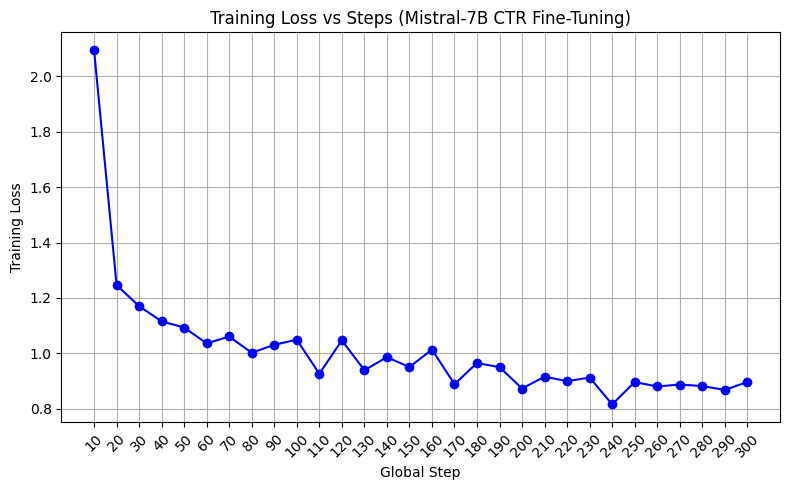

In [ ]:
import matplotlib.pyplot as plt
loss_values = [
    2.094800,
    1.246400,
    1.170400,
    1.115600,
    1.093300,
    1.036100,
    1.061000,
    1.002100,
    1.031200,
    1.049400,
    0.926500,
    1.046900,
    0.939400,
    0.986300,
    0.950700,
    1.013700,
    0.888900,
    0.965200,
    0.950300,
    0.873200,
    0.916100,
    0.899700,
    0.912800,
    0.816000,
    0.896500,
    0.880600,
    0.887600,
    0.882200,
    0.868100,
    0.896700,
]
steps = list(range(10, 10 * (len(loss_values) + 1), 10))

plt.figure(figsize=(8, 5))
plt.plot(steps, loss_values, marker='o', linestyle='-', color='blue')

plt.title("Training Loss vs Steps (Mistral-7B CTR Fine-Tuning)")
plt.xlabel("Global Step")
plt.ylabel("Training Loss")
plt.grid(True)
plt.xticks(steps, rotation=45)
plt.tight_layout()
plt.show()
